<a href="https://colab.research.google.com/github/hdemma/covid-19/blob/master/analysis/nashville_incident_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Incident Visualization

The datasets used in this notebook come from the Nashville Fire Department. They can be found under Teams > incident-analytics > General > Datasets > FireDepartment > geo_out_july.csv

In [1]:
import pandas as pd
import datetime as dt
import plotly.express as px

# import folium
# from folium import plugins

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 12)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'seaborn'

In [2]:
pip install seaborn

     |████████████████████████████████| 285 kB 8.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# helper functions
def get_date_object(date):
    '''
    date : str, YYYY-MM-DD
    '''
    return dt.datetime.strptime(date, '%Y-%m-%d').date()


def get_time_object(time):
    '''
    time = HH:MM AM or PM (12 hour format)
    '''
    
    return dt.datetime.strptime(time, '%I:%M %p').time()

# Important Considerations


* Ensure that geo_out_july_2020.xlsx has been manually uploaded into Google Drive (dataset can be found under Teams > incident-analytics > General > Datasets > FireDepartment > geo_out_july.csv) 

In [ ]:
# mount to your own Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# read from your own Google Drive (alter file path to reflect location of the CSV in your own Google Drive)
incident_df = pd.read_csv('/content/drive/My Drive/your_file_path_here/geo_out_july_2020.csv')

In [5]:
incident_df.head(2)

,_id,incidentNumber,latitude,longitude,emdCardNumber,alarmDateTime,arrivalDateTime,weather,location.type,location.coordinates,respondingVehicles,fireZone
0,5c2e925395fad062a201f078,FFD18123100136570,36.168805,-86.786157,FFIRST,2019-01-01T03:47:20.840Z,2018-12-31T21:47:33.813-06:00,partly-cloudy-night,Point,"[-86.78615697,36.16880519]","[{""dispatchDateTime"":""2018-12-31T21:47:20.84-0...",2E
1,5c2e925395fad062a201f079,FFD18123100136575,36.076574,-86.711212,25B2B,2019-01-01T03:59:06.560Z,2018-12-31T22:07:14.927-06:00,partly-cloudy-night,Point,"[-86.7112123,36.0765745]","[{""dispatchDateTime"":""2018-12-31T21:59:06.56-0...",6B


In [6]:
# check that 2020 data exists
incident_df.loc[incident_df['_id'] == '5f07bbf595fad02c1452db55']

,_id,incidentNumber,latitude,longitude,emdCardNumber,alarmDateTime,arrivalDateTime,weather,location.type,location.coordinates,respondingVehicles,fireZone
173715,5f07bbf595fad02c1452db55,FFD20062000063215,36.158818,-86.799875,12D2,2020-06-20T10:08:33.130Z,2020-06-20T05:13:57.767-05:00,partly-cloudy-night,Point,"[-86.79987543,36.158818]","[{""dispatchDateTime"":""2020-06-20T05:08:33.13-0...",19C


### Data Preprocessing
1. convert alarmDateTime to datetime
2. convert alarmDateTime datetime from UTC to Central Time
3. create date and time fields

In [7]:
# 1. convert alarmDateTime to datetime
incident_df['alarm_datetime'] = incident_df['alarmDateTime'].str.replace('T', ' ')
incident_df['alarm_datetime'] = incident_df['alarm_datetime'].str.replace('Z', '')
incident_df['alarm_datetime'] = pd.to_datetime(incident_df['alarm_datetime'])

In [8]:
# 2. convert alarm datetime from UTC to central time
incident_df['alarm_datetime'] = incident_df['alarm_datetime'].dt.tz_localize("GMT").dt.tz_convert('America/Chicago').dt.tz_localize(None)

In [9]:
# 3. create date and time fields
incident_df['alarm_date'] = pd.to_datetime(incident_df['alarm_datetime']).dt.date
incident_df['alarm_time'] = pd.to_datetime(incident_df['alarm_datetime']).dt.time
incident_df['alarm_year'] = pd.to_datetime(incident_df['alarm_datetime']).dt.year

In [10]:
incident_df.head(2)

,_id,incidentNumber,latitude,longitude,emdCardNumber,alarmDateTime,arrivalDateTime,weather,location.type,location.coordinates,respondingVehicles,fireZone,alarm_datetime,alarm_date,alarm_time,alarm_year
0,5c2e925395fad062a201f078,FFD18123100136570,36.168805,-86.786157,FFIRST,2019-01-01T03:47:20.840Z,2018-12-31T21:47:33.813-06:00,partly-cloudy-night,Point,"[-86.78615697,36.16880519]","[{""dispatchDateTime"":""2018-12-31T21:47:20.84-0...",2E,2018-12-31 21:47:20.840,2018-12-31,21:47:20.840000,2018
1,5c2e925395fad062a201f079,FFD18123100136575,36.076574,-86.711212,25B2B,2019-01-01T03:59:06.560Z,2018-12-31T22:07:14.927-06:00,partly-cloudy-night,Point,"[-86.7112123,36.0765745]","[{""dispatchDateTime"":""2018-12-31T21:59:06.56-0...",6B,2018-12-31 21:59:06.560,2018-12-31,21:59:06.560000,2018


# Plot Time Series


In [11]:
# get entries starting in 2019
cutoff_date = get_date_object('2019-01-01')
df = incident_df[incident_df['alarm_date'] >= cutoff_date]
df.head(2)

,_id,incidentNumber,latitude,longitude,emdCardNumber,alarmDateTime,arrivalDateTime,weather,location.type,location.coordinates,respondingVehicles,fireZone,alarm_datetime,alarm_date,alarm_time,alarm_year
15,5c2e926595fad062a201f0bb,FFD19010100000220,36.039535,-86.646701,29D5V,2019-01-01T18:50:32.400Z,2019-01-01T12:55:04.147-06:00,cloudy,Point,"[-86.64670098,36.03953518]","[{""dispatchDateTime"":""2019-01-01T12:50:32.4-06...",26B,2019-01-01 12:50:32.400,2019-01-01,12:50:32.400000,2019
16,5c2e926595fad062a201f0bc,FFD19010100000241,36.128413,-86.851206,17B1G,2019-01-01T19:36:35.923Z,2019-01-01T13:40:54.747-06:00,cloudy,Point,"[-86.85120577,36.12841286]","[{""dispatchDateTime"":""2019-01-01T13:36:35.923-...",17D,2019-01-01 13:36:35.923,2019-01-01,13:36:35.923000,2019


In [ ]:
day_df = df[['_id','alarm_date', 'alarm_year']]
day_df = day_df.groupby(['alarm_date', 'alarm_year']).size()
day_df = day_df.reset_index()
day_df.columns = ['Date', 'Year','Number of Accidents']
day_df['Year'] = day_df['Year'].astype('category')

In [81]:
day_df.tail()

,Date,Year,Number of Accidents
551,2020-07-05,2020,166
552,2020-07-06,2020,194
553,2020-07-07,2020,183
554,2020-07-08,2020,191
555,2020-07-09,2020,162


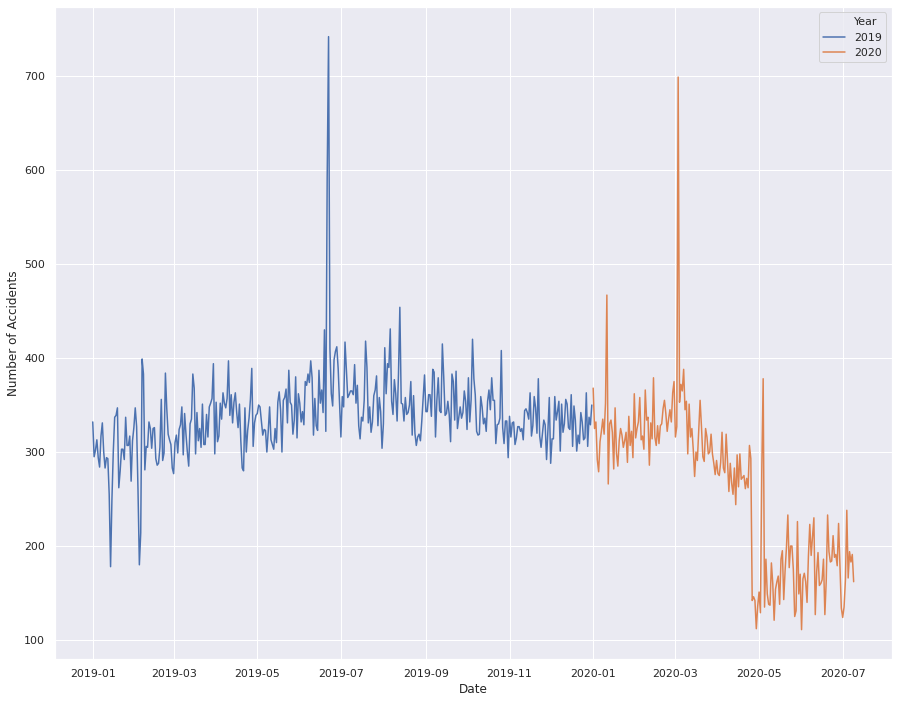

In [15]:
# plot # of accidents per day
sns.lineplot(x='Date', y='Number of Accidents', hue='Year',
             data=day_df, ci=None)

# Plot Accident Heatmap

In [ ]:
# *** OLD VERSION USING FOLIUM ***
# def plot_accident_heatmap(df, start_date, end_date, start_time, end_time):

#   date_condition = ((df['alarm_date'] >= start_date) & (df['alarm_date'] <= end_date))
#   time_condition = ((df['alarm_time'] >= start_time) & (df['alarm_time'] <= end_time))
  
#   result = df.loc[date_condition & time_condition][['latitude', 'longitude', '_id']]

#   m = folium.Map([36.162208, -86.774372], zoom_start=12)
#   accident_arr = df[['latitude', 'longitude']].to_numpy()
#   m.add_child(plugins.HeatMap(data=accident_arr, radius=10))

#   return m

In [125]:
# *** NEW VERSION USING PLOTLY ***
def plot_accident_heatmap(df, start_date, end_date, start_time, end_time):

  date_condition = ((df['alarm_date'] >= start_date) & (df['alarm_date'] <= end_date))
  time_condition = ((df['alarm_time'] >= start_time) & (df['alarm_time'] <= end_time))
  
  result = df.loc[date_condition & time_condition][['latitude', 'longitude', '_id']]
  # print(result.shape[0])

  fig = px.density_mapbox(result, lat='latitude', lon='longitude', radius=5,
                        center=dict(lat=36.16228, lon=-86.774372), zoom=10,
                        mapbox_style="stamen-terrain")
  fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,)
  
  return fig

In [121]:
start_date = get_date_object('2020-01-01')
end_date = get_date_object('2020-07-01')
start_time = get_time_object('12:00 AM')
end_time = get_time_object('11:59 PM')

In [126]:
plot_accident_heatmap(incident_df, start_date, end_date, start_time, end_time)

# dash TODO: create range sliders for date, time, and radius

In [115]:
def get_monthly_accident_count(df, start_date, end_date, start_time, end_time):

  date_condition = ((df['alarm_date'] >= start_date) & (df['alarm_date'] <= end_date))
  time_condition = ((df['alarm_time'] >= start_time) & (df['alarm_time'] <= end_time))
  
  result = df.loc[date_condition & time_condition][['alarm_datetime']]

  result['month_year'] = result['alarm_datetime'].dt.to_period('M')
  result['month_year'] = result['month_year'].astype(str)

  result = result.groupby(['month_year']).count().reset_index()
  result.columns = ['date', 'accident count']

  return px.bar(result, x='date', y='accident count')

In [117]:
start_date = get_date_object('2019-01-01')
end_date = get_date_object('2020-06-30')
start_time = get_time_object('12:00 AM')
end_time = get_time_object('11:59 PM')

get_monthly_accident_count(incident_df, start_date, end_date, start_time, end_time)

# dash TODO: create range sliders for date, time